The best parameters of linear are {'C': 32.0, 'kernel': 'linear'}
 with a validation score of 69.37%
The best parameters of rbf are {'C': 2.0, 'gamma': 11.313708498984761, 'kernel': 'rbf'}
 with a validation score of 74.77%
The best parameters of poly are {'C': 0.03125, 'degree': 1, 'gamma': 32.0, 'kernel': 'poly'}
 with a validation score of 69.37%

test accuracy of linear = 68.92%
test accuracy of rbf = 64.86%
test accuracy of poly = 68.92%

linear
Sensitivity = 67.86%
Specificity = 72.22%
LR+ = 2.44
LR- = 0.45
PPV = 88.37%
NPV = 41.94%
Accuracy = 68.92%

rbf
Sensitivity = 55.36%
Specificity = 94.44%
LR+ = 9.96
LR- = 0.47
PPV = 96.88%
NPV = 40.48%
Accuracy = 64.86%

poly
Sensitivity = 67.86%
Specificity = 72.22%
LR+ = 2.44
LR- = 0.45
PPV = 88.37%
NPV = 41.94%
Accuracy = 68.92%



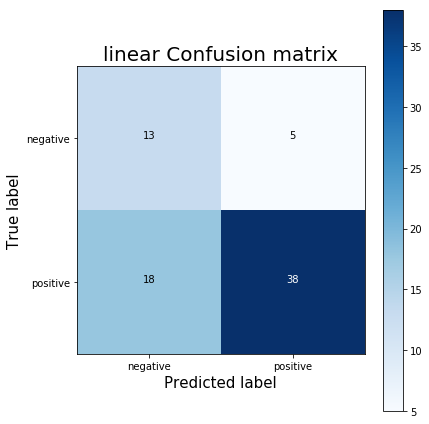

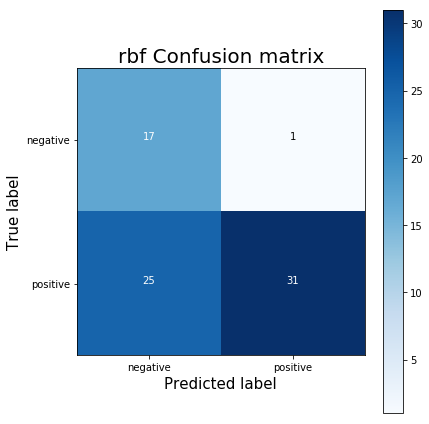

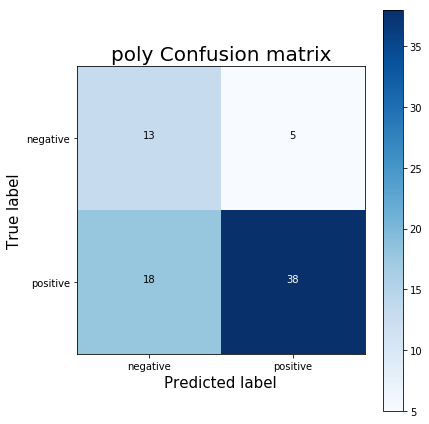

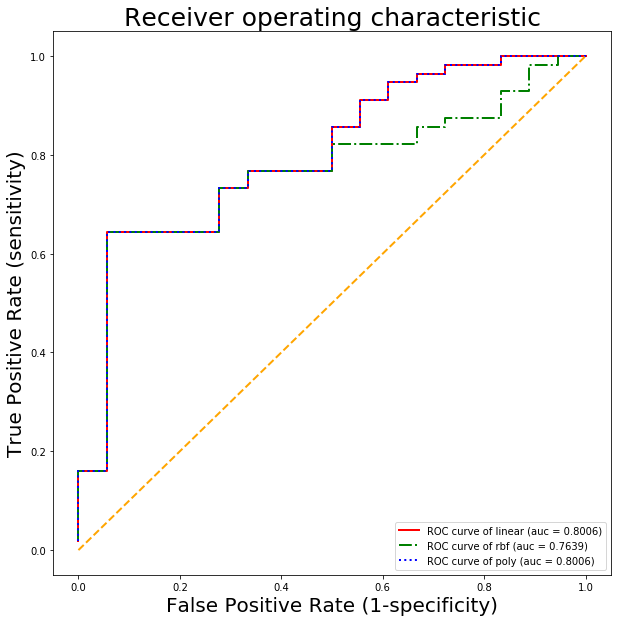

In [5]:
# import models
import matplotlib.pyplot as plt 
import numpy as np
import xlrd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import itertools
from sklearn.metrics import confusion_matrix

# load data
## Pathology for train
data = xlrd.open_workbook('Pathology.xlsx').sheets()[0]
X_tra = np.zeros((111, 1))
#X_tra[:, 0] = data.col_values(3)  # X0 = Integrated backscatter
X_tra[:, 0] = data.col_values(4)  # X1 = Q factor (HHT)
#X_tra[:, 2] = data.col_values(6)  # X2 = Homogeneity factor

### scaling to 0~1
Scaler = MinMaxScaler(copy=True, feature_range=(0, 1)).fit(X_tra)
X_train = Scaler.transform(X_tra)

nrows = data.nrows
y_train = []
for i in range(nrows):  # y = 'T' or 'F' from Pathology data 
    if data.cell(i,1).value < 10:
        y_train.append(0)
    elif data.cell(i,1).value >= 10:
        y_train.append(1)
y_train = np.ravel(y_train)   # Return a contiguous flattened array
class_names = np.ravel(['negative', 'positive'])  

## New Pathology for test
data = xlrd.open_workbook('NPathology.xlsx').sheets()[0]
X_te = np.zeros((74, 1))
#X_te[:, 0] = data.col_values(3)  # X0 = Integrated backscatter
X_te[:, 0] = data.col_values(4)  # X1 = Q factor (HHT)
#X_te[:, 2] = data.col_values(6)  # X2 = Homogeneity factor

### scaling to 0~1
X_test = Scaler.transform(X_te)

nrows = data.nrows
y_test = []
for i in range(nrows):  # y = 'T' or 'F' from Pathology data 
    if data.cell(i,1).value < 10:
        y_test.append(0)
    elif data.cell(i,1).value >= 10:
        y_test.append(1)
y_test = np.ravel(y_test)   # Return a contiguous flattened array

# training & validation
## set CV
cv = StratifiedKFold(10)
## set parameters
C_l = []
for i in range(300, 725, 25): # C: 2**-5~2**15(half)
    C_l.append(2**(i/100))

C_r = []
for i in range(100, 525, 25): # C :2**-5~2**15(half)
    C_r.append(2**(i/100))
    
C_p = []
for i in range(-500, -75, 25): # C: 2**-5~2**15(half)
    C_p.append(2**(i/100))
    
gamma_r = []
for i in range(100, 525, 25): # gamma: 2**-15~2**3(half)
    gamma_r.append(2**(i/100))

gamma_p = []
for i in range(100, 525, 25): # gamma: 2**-15~2**3(half)
    gamma_p.append(2**(i/100))

## SVC_linear
linear_prarmeters = [{'kernel': ['linear'], 'C': C_l}]
clf_linear = GridSearchCV(SVC(), linear_prarmeters, cv=cv, n_jobs=3).fit(X_train, y_train)
print('The best parameters of linear are {0}\n with a validation score of {1:.2%}'
      .format(clf_linear.best_params_, clf_linear.best_score_))

## SVC_rbf
rbf_prarmeters = [{'kernel': ['rbf'], 'C': C_r, 'gamma': gamma_r}]
clf_rbf = GridSearchCV(SVC(), rbf_prarmeters, cv=cv, n_jobs=3).fit(X_train, y_train)
print('The best parameters of rbf are {0}\n with a validation score of {1:.2%}'
      .format(clf_rbf.best_params_, clf_rbf.best_score_))

## SVC_poly
poly_prarmeters = [{'kernel': ['poly'], 'C': C_p, 'gamma': gamma_p, 'degree': [1, 2, 3]}]
clf_poly = GridSearchCV(SVC(), poly_prarmeters, cv=cv, n_jobs=3).fit(X_train, y_train)
print('The best parameters of poly are {0}\n with a validation score of {1:.2%}\n'
      .format(clf_poly.best_params_, clf_poly.best_score_))

# test
## SVC_linear
test_predict_linear = clf_linear.predict(X_test)
test_score_linear = clf_linear.score(X_test, y_test)
print('test accuracy of linear = {0:.2%}'.format(test_score_linear))
dec_linear = clf_linear.decision_function(X_test)

## SVC_rbf
test_predict_rbf = clf_rbf.predict(X_test)
test_score_rbf = clf_rbf.score(X_test, y_test)
print('test accuracy of rbf = {0:.2%}'.format(test_score_rbf))
dec_rbf = clf_rbf.decision_function(X_test)

## SVC_poly
test_predict_poly = clf_poly.predict(X_test)
test_score_poly = clf_poly.score(X_test, y_test)
print('test accuracy of poly = {0:.2%}\n'.format(test_score_poly))
dec_poly = clf_poly.decision_function(X_test)

# Confusion matrix 
## define confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    global i
    print('{0}'.format(kernel[i]))
    print('Sensitivity = {0:.2%}'.format(cm[1,1]/(cm[1,0]+cm[1,1])))
    print('Specificity = {0:.2%}'.format(cm[0,0]/(cm[0,0]+cm[0,1])))
    print('LR+ = {0:.2f}'.format((cm[1,1]/(cm[1,0]+cm[1,1]))/(cm[0,1]/(cm[0,0]+cm[0,1]))))
    print('LR- = {0:.2f}'.format((cm[1,0]/(cm[1,0]+cm[1,1]))/(cm[0,0]/(cm[0,0]+cm[0,1]))))
    print('PPV = {0:.2%}'.format(cm[1,1]/(cm[0,1]+cm[1,1])))
    print('NPV = {0:.2%}'.format(cm[0,0]/(cm[0,0]+cm[1,0])))
    print('Accuracy = {0:.2%}\n'.format((cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.title(title, size = 20)
    plt.ylabel('True label', size = 15)
    plt.xlabel('Predicted label', size = 15)

kernel = ['linear', 'rbf', 'poly']
pre_kernel = [test_predict_linear, test_predict_rbf, test_predict_poly]  # predict of each kernel

for i in range(0,3):                                                     
    ## Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, pre_kernel[i])
    np.set_printoptions(precision=4)

    ## Plot non-normalized confusion matrix
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='{0} Confusion matrix'.format(kernel[i]))
plt.show()

# ROC curve
## compute ROC and AUC
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()

dec = [dec_linear, dec_rbf, dec_poly]   # direction of each kernel          

for i in range(0,3):                                                    
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, dec[i])
    roc_auc[i] = auc(fpr[i], tpr[i])  

## plot
plt.figure(figsize=(10,10))
lw=2
colors = ['red', 'green', 'blue']
linestyles = ['-', '-.', ':']
for i, color, linestyle in zip(range(0,3), colors, linestyles):                 
    plt.plot(fpr[i], tpr[i], color=color, linestyle=linestyle, lw=lw, 
             label='ROC curve of {0} (auc = {1:.4f})'.format(kernel[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', size = 20)
plt.ylabel('True Positive Rate (sensitivity)', size = 20)
plt.title('Receiver operating characteristic', size = 25)
plt.legend(loc='lower right')
plt.show()